In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc ,classification_report,roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from zhon.hanzi import punctuation
import numpy as np
import pandas as pd
import jieba
from sklearn.externals import joblib
from sklearn.svm import SVC
import sys 
import re

In [2]:
dir_1 = r'all_data_new_1.csv'

df = pd.read_csv(dir_1)
print(df.shape)
df.head()

(16251, 3)


,text,title,type
0,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",1
1,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,1
2,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",1
3,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,1
4,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,1


文本预处理

In [3]:
def cleanlines(line,remove_stopwords=False):   
    p1=re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
    p2=re.compile(r'[(][: @ . , ？！\s][)]')
    p3=re.compile(r'[「『]')
    p4=re.compile(r'[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）0-9 , : ; \-\ \[\ \]\ ]')
    p5=re.compile(r'[^a-zA-Z]')
    line=p1.sub(r' ',line)
    line=p2.sub(r' ',line)
    line=p3.sub(r' ',line)
    line=p4.sub(r' ',line)
    line=p5.sub(r' ',line)
    words = line.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in eng_stopwords]
    return words

In [4]:
eng_stopwords = [line.rstrip() for line in open('stop_words.txt')]
eng_stopwords[:5]

["'d", "'ll", "'m", "'re", "'s"]

In [6]:
df['text'] = df['text'].astype(str)
sents = df['text']
text_words=[cleanlines(sent,remove_stopwords=True) for sent in sents]

In [7]:
df['title'] = df['title'].astype(str)
title_sents = df['title']
title_words=[cleanlines(sent,remove_stopwords=True) for sent in title_sents]

In [8]:
def concat_text(text_words,title_words):
    concat_text = []
    for i in range(len(text_words)):
        temp = text_words[i]+title_words[i]
        concat_text.append(temp)
    return concat_text

concat_text = concat_text(text_words,title_words)

In [9]:
concat_text[:1]

[['stood',
  'trump',
  'tower',
  'half',
  'hour',
  'handing',
  'cash',
  'mementos',
  'president',
  'elect',
  'mini',
  'gold',
  'wrapped',
  'chocolate',
  'bricks',
  'stamped',
  'trump',
  'trump',
  'monogrammed',
  'sweaters',
  'towels',
  'glassware',
  'trump',
  'cologne',
  'bought',
  'sons',
  'shanon',
  'loggins',
  'lufkin',
  'tex',
  'golden',
  'shopping',
  'bag',
  'embossed',
  'trump',
  'crest',
  'carried',
  'bottles',
  'success',
  'trump',
  'fragrance',
  'successful',
  'explained',
  'business',
  'donald',
  'trump',
  'people',
  'flocking',
  'midtown',
  'manhattan',
  'skyscraper',
  'dining',
  'restaurants',
  'buying',
  'wares',
  'reporters',
  'fastidiously',
  'chronicling',
  'comings',
  'goings',
  'transition',
  'team',
  'branded',
  'properties',
  'providing',
  'backdrop',
  'television',
  'live',
  'shots',
  'trump',
  'staid',
  'task',
  'preparing',
  'assume',
  'presidency',
  'exercise',
  'conspicuous',
  'promotio

In [10]:
def build_sentence_vector(text, size,imdb_w2v):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += imdb_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [11]:
#word2vec
def get_train_vecs(x_samples):
    n_dim = 150
    #initialize model and dict
    rj_w2v = Word2Vec(size=n_dim, min_count=5)
    rj_w2v.build_vocab(x_samples)
    
    #train
    rj_w2v.train(x_samples,total_examples=rj_w2v.corpus_count, epochs=300)
    
    all_vecs = np.concatenate([build_sentence_vector(z, n_dim,rj_w2v) for z in x_samples])
    #train_vecs = scale(train_vecs)
    
    np.save('x_samples.npy',all_vecs)
    print(all_vecs.shape)


In [12]:
get_train_vecs(concat_text)

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(16251, 150)


In [12]:
def get_data():
    train_vecs=np.load('x_samples.npy')
    return train_vecs
x_samples_arr = get_data()

In [13]:
x_samples_arr.shape

(16251, 150)

In [14]:
y = np.array(df['type'])
print(len(y))

16251


In [15]:

x_train,x_val,y_train,y_val = train_test_split(x_samples_arr,y,test_size=0.2,random_state=10,stratify=y)

In [16]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(type(y_train))
print(y_val[:100])

(13000, 150)
(3251, 150)
(13000,)
(3251,)
<class 'numpy.ndarray'>
[1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0]


In [17]:
classifier_names = ['LR','RBF SVM','Random Forest','Boosted Trees']

classifiers = [LogisticRegression(random_state=0),SVC(kernel='rbf'),
               RandomForestClassifier(max_depth=6, n_estimators=60),
               GradientBoostingClassifier(n_estimators=60, learning_rate=0.9,max_depth=5)]

In [18]:
#result to dict
import time
clf_results={}
for i,model in zip(classifier_names,classifiers):
    start = time.time()
    model.fit(x_train, y_train)
    pred_y = model.predict(x_val)
    end = time.time()
    if i == 'LR':
        pred_y = model.predict_proba(x_val) 
    clf_results[i]=pred_y
    print(i,end-start)

//anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR 0.8508777618408203


//anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RBF SVM 13.947383165359497
Random Forest 3.9673540592193604
Boosted Trees 27.46988606452942


In [19]:
print(clf_results['RBF SVM'])
print(type(clf_results['RBF SVM']))
print(clf_results['LR'])
LR_2 = []
for i in range(0,len(clf_results['LR'])):
    LR_2.append(clf_results['LR'][i][1])
LR_2 = np.array(LR_2)
print(LR_2)


[1 0 0 ... 0 1 0]
<class 'numpy.ndarray'>
[[0.04391492 0.95608508]
 [0.22920395 0.77079605]
 [0.99806961 0.00193039]
 ...
 [0.97713318 0.02286682]
 [0.01577077 0.98422923]
 [0.79040469 0.20959531]]
[0.95608508 0.77079605 0.00193039 ... 0.02286682 0.98422923 0.20959531]


In [20]:
dir_2 = r'result_new.csv'

predict_result = pd.read_csv(dir_2)
predict_result.head()

,predict,label
0,9.999269e-01,1
1,5.034981e-06,0
2,7.942072e-11,0
3,2.241843e-08,0
4,5.556067e-05,0


In [21]:
predict_result['svm'] = clf_results['RBF SVM']
predict_result['LR'] = LR_2

In [22]:
predict_result.tail()

,predict,label,svm,LR
3246,9.999498e-01,1,1,0.368550
3247,3.657237e-07,0,0,0.005616
3248,3.425474e-10,0,0,0.022867
3249,9.999607e-01,1,1,0.984229
3250,4.565080e-08,0,0,0.209595


In [31]:
predict_result['final_result'] = 0.1 * predict_result['svm'] + 0.99 * predict_result['predict']
predict_result.head()

,predict,label,svm,LR,final_result
0,9.999269e-01,1,1,0.956085,1.089928e+00
1,5.034981e-06,0,0,0.770796,4.984632e-06
2,7.942072e-11,0,0,0.001930,7.862651e-11
3,2.241843e-08,0,0,0.000924,2.219425e-08
4,5.556067e-05,0,1,0.499932,1.000550e-01


In [32]:
result = np.array(predict_result['final_result'])
print(result)
print(type(result))
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(result)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, results))


[1.08992766e+00 4.98463150e-06 7.86265128e-11 ... 3.39121961e-10
 1.08996105e+00 4.51942960e-08]
<class 'numpy.ndarray'>
[[2266    4]
 [  24  957]]


In [33]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print('precision:',precision_score(y_val, results))
print('recall:',recall_score(y_val, results))
print('f1:',f1_score(y_val, results))
print('-========')

precision: 0.9958376690946931
recall: 0.9755351681957186
f1: 0.9855818743563336
-========


In [34]:
y_scores = pd.DataFrame(results)[0].values
print(y_scores)

[1 0 0 ... 0 1 0]


In [35]:
auc_value = roc_auc_score(y_val, y_scores)
print(auc_value)

0.9868865268291368


In [36]:
#W2V-LR + TEXTCNN
predict_result['final_result_lr'] = 0.4 * predict_result['LR'] + 0.6 * predict_result['predict']
predict_result.head()

,predict,label,svm,LR,final_result,final_result_lr
0,9.999269e-01,1,1,0.956085,1.089928e+00,0.982390
1,5.034981e-06,0,0,0.770796,4.984632e-06,0.308321
2,7.942072e-11,0,0,0.001930,7.862651e-11,0.000772
3,2.241843e-08,0,0,0.000924,2.219425e-08,0.000370
4,5.556067e-05,0,1,0.499932,1.000550e-01,0.200006


In [37]:
result = np.array(predict_result['final_result_lr'])
print(result)
print(type(result))
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(result)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, results))


[9.82390187e-01 3.08321440e-01 7.72155552e-04 ... 9.14672910e-03
 9.93668087e-01 8.38381528e-02]
<class 'numpy.ndarray'>
[[2266    4]
 [  26  955]]


In [38]:
y_scores = pd.DataFrame(results)[0].values
print(y_scores)

[1 0 0 ... 0 1 0]


In [39]:
auc_value = roc_auc_score(y_val, y_scores)
print(auc_value)

0.9858671588372918


In [18]:
from sklearn.metrics import confusion_matrix

for i in clf_results.keys():
    print(i,confusion_matrix(y_val, clf_results[i]))
    print('-========')

LR [[2138  132]
 [ 159  822]]
-========
RBF SVM [[2136  134]
 [ 155  826]]
-========
Random Forest [[2150  120]
 [ 280  701]]
-========
Boosted Trees [[2138  132]
 [ 150  831]]
-========


In [19]:
from sklearn.metrics import precision_score, recall_score
# f1 score
from sklearn.metrics import f1_score
for i in clf_results.keys():
    print('precision:',i,precision_score(y_val, clf_results[i]))
    print('recall:',i,recall_score(y_val, clf_results[i]))
    print('f1:',i,f1_score(y_val, clf_results[i]))
    print('-========')

precision: LR 0.8616352201257862
recall: LR 0.8379204892966361
f1: LR 0.8496124031007751
-========
precision: RBF SVM 0.8604166666666667
recall: RBF SVM 0.8419979612640163
f1: RBF SVM 0.8511076764554353
-========
precision: Random Forest 0.853836784409257
recall: Random Forest 0.7145769622833843
f1: Random Forest 0.7780244173140954
-========
precision: Boosted Trees 0.8629283489096573
recall: Boosted Trees 0.8470948012232415
f1: Boosted Trees 0.8549382716049383
-========


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
y_scores = {}
for i in clf_results.keys():
    y_scores[i] = pd.DataFrame(clf_results[i])[0].values
print(y_scores)


In [23]:
auc_value = {}
for i in clf_results.keys():
    auc_value[i] = roc_auc_score(y_val, y_scores[i])
print(auc_value)

{'LR': 0.8898853547804767, 'RBF SVM': 0.8914835621298055, 'Random Forest': 0.8308567630800181, 'Boosted Trees': 0.8944725107437794}


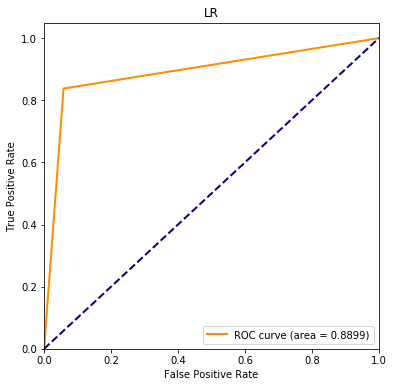

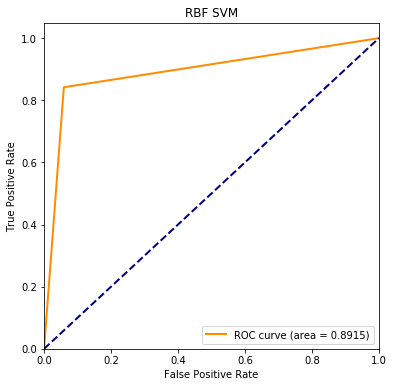

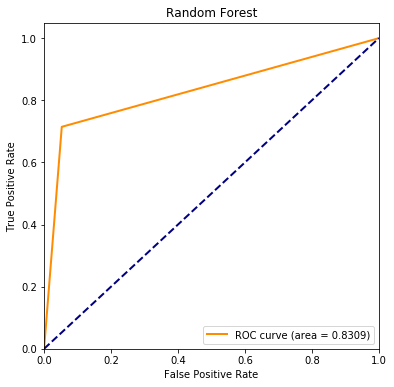

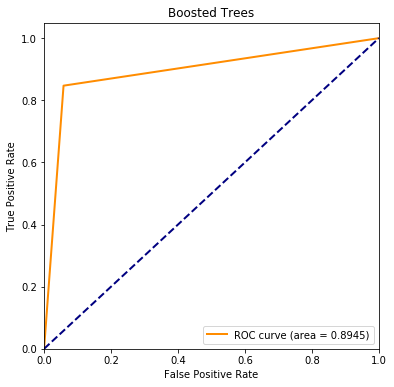

In [27]:
for i in clf_results.keys():
    fpr, tpr, thresholds = roc_curve(y_val, y_scores[i], pos_label=1.0)
    plt.figure(figsize=(6,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value[i])
    plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(i))
    plt.legend(loc="lower right")

In [41]:
print(10/10)

1.0
